# <center>Ensemble Learning</center>
---

**<font color='red'>wisdom of the crowd: </font>** In many cases, the aggregated answer (from many people) is better than an expert's answer.

If you aggregate the predictions of a group of predictors (clfs or regs), you will often get better predictions than with the best individual predictor. The group of predictors is called an **<font color='red'>ensemble</font>**. This technique is called **<font color='red'>Ensemble Learning</font>**, and an Ensemble Learning algorithm is called an **<font color='red'>Ensemble method</font>**.

In fact, the winning solutions in ML competitions often involve several Ensemble methods.

<br>

Two families of ensemble methods are usually distinguished:

- In **<font color='red'>averaging methods:</font>** the driving principles is to **build several estimators independently and then to average their predictions**. On average, the combined estimator is usually better than any of the single estimator because its variance is reduced.

  - Bagging methods
  - Forests of randomized trees
  - ...

- In **<font color='red'>boosting methods:</font>** base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

  - AdaBoost
  - Gradient Tree Boosting
  - ...

In [1]:
# Common imports
import os
import sys
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
# warnings.filterwarnings(action='ignore', message="^internal gelsd")

In [2]:
print('python version:', sys.version_info)
print('matplotlib version:', mpl.__version__)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sklearn.__version__)

python version: sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib version: 3.1.2
numpy version: 1.18.1
pandas version: 1.0.1
scikit-learn version: 0.22.1


## 1. Voting classifiers

**<font color='crimson'>Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.</font>** -- From [sklearn](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

### 1.1 Hard voting classifier

Suppose you have trained a few clfs, each one achieving about 80% acc. <font color='crimson'>A very simple way to create an even better clf is to aggregate the predictions of each clf and predict the class that gets the most votes.</font> This majority-vote clf is called a **<font color='red' size=3>hard voting classifier</font>**. This voting clf is <font color='crimson'>often get a higher accuracy than the best clf in the ensemble</font>.

In fact, even if each classifier is a **<font color='red'>weak learner</font>** (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.

However, this is **only true if all classifiers are perfectly independent, making uncorrelated errors**, which is clearly not the case because they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy.

<div class="alert alert-block alert-info">
    <b>Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.</b>
</div>


![Hard voting clf predictions](./figs/chap07-figs/hard-voting-clf-predictions.png)

<center><i>Hard voting classifier predictions</i></center>

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# Generate a moon dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

print("The shape of `x_train`:", x_train.shape)
print("The shape of `y_train`:", y_train.shape)
print("The shape of `x_test`:", x_test.shape)

The shape of `x_train`: (375, 2)
The shape of `y_train`: (375,)
The shape of `x_test`: (125, 2)


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Train a HARD voting classifier composed of 3 diverse classifiers
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', random_state=42)

hard_voting_clf = VotingClassifier(
    # List of (str, estimator) tuples
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    # Default, use predicted class labels for majority rule voting
    voting='hard',
    n_jobs=-1)
hard_voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [5]:
from sklearn.metrics import accuracy_score

# Look at each clf's acc on the test
for clf in (log_clf, rnd_clf, svm_clf, hard_voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("Acc: {:.4f} [{}]".format(
        accuracy_score(y_test, y_pred), clf.__class__.__name__))

Acc: 0.8640 [LogisticRegression]
Acc: 0.8960 [RandomForestClassifier]
Acc: 0.8960 [SVC]
Acc: 0.9120 [VotingClassifier]


> **<font color='crimson'>学会这种对齐方式！</font>**

```python
# Look at each clf's acc on the test
from sklearn.model_selection import cross_val_score

for clf in (log_clf, rnd_clf, svm_clf, hard_voting_clf):
    scores = cross_val_score(clf, x_train, y_train, scoring='accuracy',
                             cv=5, n_jobs=-1)
    print("Acc: {:.4f} (+/- {:.4f}) [{}]".format(
        scores.mean(), scores.std(), clf.__class__.__name__))
```

The voting clf slightly outperforms all the individual classifiers.

### 1.2 Soft voting classifier

If all clfs are able to estimate class probabilities (i.e., they all have a `predict_proba()` method), then you can tell Scikit-Learn to <font color='crimson'>predict the class with the highest class probability, averaged over all the individual classifiers</font>. This is called **<font color='red' size=3>soft voting</font>**.

**<font color='crimson'>It often achieves higher performance than hard voting because it gives more weight to highly confident votes.</font>**

All you need to do is **replace `voting='hard'` with `voting='soft'` and ensure that all clfs can estimate class probabilities**.

> **<font color='blue'>Notice:</font>** This is not the case for the `SVC` class by default, so you need to set its `probability=True` (this will make the `SVC` class use cv to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method).

In [6]:
# Train a SOFT voting classifier composed of 3 diverse classifiers
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)

soft_voting_clf = VotingClassifier(
    # List of (str, estimator) tuples
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    # Predict the class label based on the argmax of the sums of the predicted
    # probabilities, which is recommended for an ensemble of well-calibrated classifiers.
    voting='soft',
    n_jobs=-1)
soft_voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [7]:
# Look at each clf's acc on the test
for clf in (log_clf, rnd_clf, svm_clf, soft_voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("Acc: {:.4f} [{}]".format(
        accuracy_score(y_test, y_pred), clf.__class__.__name__))

Acc: 0.8640 [LogisticRegression]
Acc: 0.8960 [RandomForestClassifier]
Acc: 0.8960 [SVC]
Acc: 0.9200 [VotingClassifier]


When specific **`weights`** are provided, the predicted class probabilities for each classifier are collected, multiplied by the classifier weight, and averaged. The final class label is then derived from the class label with the highest average probability.

In [8]:
# Train a SOFT voting classifier composed of 3 diverse classifiers with weights specified
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)

soft_voting_clf = VotingClassifier(
    # List of (str, estimator) tuples
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    # Predict the class label based on the argmax of the sums of the predicted
    # probabilities, which is recommended for an ensemble of well-calibrated classifiers.
    voting='soft',
    # Use uniform weights if None (default)
    weights=[1, 2, 2],
    n_jobs=-1)
soft_voting_clf.fit(x_train, y_train)

# Look at each clf's acc on the test
for clf in (log_clf, rnd_clf, svm_clf, soft_voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("Acc: {:.4f} [{}]".format(
        accuracy_score(y_test, y_pred), clf.__class__.__name__))

Acc: 0.8640 [LogisticRegression]
Acc: 0.8960 [RandomForestClassifier]
Acc: 0.8960 [SVC]
Acc: 0.9120 [VotingClassifier]


### 1.3  Tune the hyperparameters of the individual estimators

In [9]:
# Tune the hyperparameters of the individual estimators
from sklearn.model_selection import GridSearchCV

log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)

soft_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft',
    weights=None,  # default
    n_jobs=-1)

# Train
param_grid = {'lr__C': [1, 10, 100], 'rf__n_estimators': [50, 100, 200]}
grid_search = GridSearchCV(estimator=soft_voting_clf, param_grid=param_grid,
                           cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Test
y_pred = grid_search.predict(x_test)
print("Acc: {:.4f} [{}]".format(
        accuracy_score(y_test, y_pred), grid_search.__class__.__name__))

Acc: 0.9120 [GridSearchCV]


## 2. Bagging methods

Bagging methods form a class of algorithms which build several instances of a black-box estimator **on random subsets** of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to <font color='crimson'>reduce the variance of a base estimator</font> (e.g., a decision tree), <font color='crimson'>by introducing randomization into its construction procedure and then making an ensemble out of it</font>.

### 2.1 Bagging and Pasting

**<font color='crimson'>Get a diverse set of clfs:</font>**

- <font color='crimson'>use very different training algorithms on the (same) full training set</font> (before)


- <font color='crimson'>use the same training algorithm for every predictor and train them on different random subsets of the training set</font>

  - When **sampling training set is performed with replacement**, this method is called **<font color='red'>bagging</font>** (short for **<font color='red'>bootstrap aggregating</font>**.
  
  - When **sampling the training set is performed without replacement**, it's called **<font color='red'>pasting</font>**.

<br>

Both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.

![bagging-pasting](./figs/chap07-figs/bagging-pasting.png)

<center><i>Bagging and pasting involves training several predictors on different random samples of the training set</i></center>

<br>

Once all predictors are trained, the ensemble can <font color='crimson'>make a prediction for a new instance by simply aggregating the predictions of all predictors</font>. The aggregation function is typically the **statistical mode** (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression.

<font color='crimson'>Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. <b>Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.</b></font>

Predictors can all be <font color='crimson'>trained in parallel, via different CPU cores or even different servers</font>. Similarly, <font color='crimson'>predictions can be made in parallel</font>. This is one of the reasons bagging and pasting are such popular methods: they <font color='crimson'>scale very well</font>.

In scikit-learn, **`BaggingClassifier`** and **`BaggingRegressor`** take as input a user-specified base estimator along with parameters specifying the strategy to draw random subsets.

- `max_samples` and `max_features` control the size of the subsets (in terms of samples and features)


- `bootstrap` and `bootstrap_features` control whether samples and features are drawn with or without replacement. When using a subset of the available samples the generalization accuracy can be estimated with the `out-of-bag` samples by setting `oob_score=True`.

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [11]:
bagging_clf = BaggingClassifier(
    # The base estimator to fit on random subsets of the dataset.
    DecisionTreeClassifier(random_state=42),  # Default=DecisionTree
    # The number of base estimators in the ensemble.
    n_estimators=500,
    # The number of samples to draw from X to train each base estimator.
    max_samples=100,   # Default=1.0
    max_features=1.0,  # Default
    # Whether samples are drawn with replacement.
    # If `False`, sampling without replacement is performed.
    bootstrap=True,    # Default
    # Whether features are drawn with replacement.
    bootstrap_features=False,  # Default
    # Whether to use out-of-bag samples to estimate the generalization error.
    oob_score=False,   # Default
    random_state=42)
bagging_clf.fit(x_train, y_train)

y_pred = bagging_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.904

In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(x_train, y_train)
y_pred = tree_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.856

<div class="alert alert-class alert-info">
    
<b>The <code>BaggingClassifier</code> automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a <code>predict_proba()</code> method).</b>
</div>

In [13]:
from matplotlib.colors import ListedColormap


def plot_decision_boundary(clf, x, y):
    x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
    y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    x_new = np.c_[xx.ravel(), yy.ravel()]

    y_pred = clf.predict(x_new).reshape(xx.shape)

    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(xx, yy, y_pred, alpha=0.3, cmap=custom_cmap)

    plt.plot(x[:, 0][y == 0], x[:, 1][y == 0], 'yo', alpha=0.5)
    plt.plot(x[:, 0][y == 1], x[:, 1][y == 1], 'bs', alpha=0.5)
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14, rotation=0)

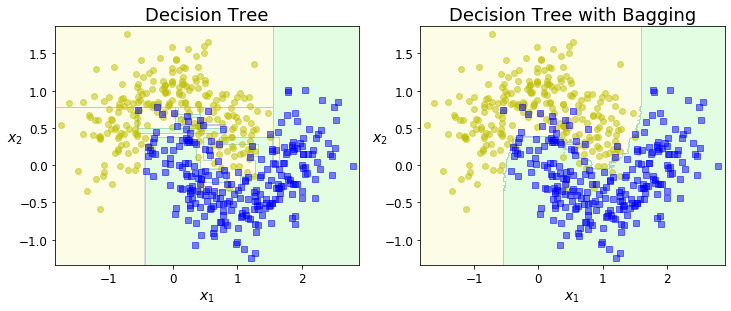

In [14]:
plt.figure(figsize=(12, 4.4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=18)

plt.subplot(122)
plot_decision_boundary(bagging_clf, X, y)
plt.title("Decision Tree with Bagging", fontsize=18)
plt.show()

**The ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).**

<div class="alert alert-block alert-info">
    <center><b><font size=3>Note</font></b></center>
    
Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so <b>bagging ends up with a slightly higher bias than pasting</b>; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance is reduced. Overall, <b>bagging often results in better models, which explains why it is generally preferred</b>.

If you have spare time and CPU power, you can use cross-validation to evaluate both bagging and pasting and select the one that works best.
</div>

### 2.2 Out-of-bag evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a `BaggingClassifier` samples m training instances with replacement (**`bootstrap=True`**), where m is the size of the training set. This <font color='crimson'>means that only about 63.2% of the training instances are sampled on average for each predictor</font>. The remaining 36.8% of the training instances that are not sampled are called **<font color='red'>out-of-bag (oob)</font>** instances. **Note that they are not the same 36.8% for all predictors.**

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can <font color='crimson'>evaluate the ensemble itself by averaging out the oob evaluations of each predictor</font>.

In scikit-learn, set `oob_score=True` when creating a `BaggingClassifier` to request an automatic oob evaluation after training. The resulting evaluation score is available through the `oob_score_` variable:

In [15]:
# Train a bagging clf with `oob_score` set to True
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True,
    max_samples=1.0,
    oob_score=True,
    random_state=42)
bagging_clf.fit(x_train, y_train)
# Score of the training dataset obtained using an out-of-bag estimate.
bagging_clf.oob_score_

0.8986666666666666

In [16]:
y_pred = bagging_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.912

In [17]:
# The oob decision function for each training instance is available
oob_decision_function = bagging_clf.oob_decision_function_
oob_decision_function.shape, y_train.shape

((375, 2), (375,))

**Since the base estimator (`DecisionTreeClassifier`) has a `predict_proba()` method, the decision function returns the class probabilities for each training instance.**

### 2.3 Random patches and Random subspaces

The `BaggingClassifier` class supports sampling the features as well - `max_features` and `bootstrap_features`. Thus, each predictor will be trained on a random subset of the input features. <font color='crimson'>This technique is particularly useful when you are dealing with high-dimensional inputs (such as images).</font>

- **<font color='red'>Random Patches:</font>** sampling both training instances and features.


- **<font color='red'>Random subspaces:</font>** keep all training instances (`bootstrap=False` and `max_samples=1.0`) but sampling features (`bootstrap_features=True` and/or `max_features=float_value_smaller_than_1`).

**<font color='crimson'>Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.</font>**

- **<font color='red'>Bagging:</font>** sampling training instances with replacement.


- **<font color='red'>Pasting:</font>** sampling training instances without replacement.

## 3. Forests of randomized trees

There are **<font color='crimson'>two averaging algorithms based on randomized DTs</font>** in `sklearn.ensemble`:

- RandomForest


- Extremely Randomized Trees

Both algorithms are perturb-and-combine techniques **<font color='crimson'>specifically designed for trees</font>**. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

### 3.1 Random Forests

- **<font color='crimson'>1st randomness</font>** In RF, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training instances. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if `bootstrap=True` (default).


- **<font color='crimson'>2nd randomness</font>** Furthermore, it searches for the best feature among a random subset of features when splitting a node during growing the tree.

**<font color='crimson'>These 2 sources of randomness result in greater tree diversity, which (again) trades a higher bias for a lower variance, generally yielding an overall better model.</font>** Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected (注入的) randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. RFs achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.


You can use the `RandomForestClassifier` instead of `BaggingClassifier` with `DecisionTreeClassifier` (same for regression).

In [18]:
# Train a random forests clf
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 max_features=1.0, random_state=42, n_jobs=-1)
rnd_clf.fit(x_train, y_train)

y_pred_rf = rnd_clf.predict(x_test)
accuracy_score(y_test, y_pred_rf)

0.912

**`RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.**

In contrast to the [original publication](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf), the Scikit-Learn implementation combines clfs by averaging their probabilistic prediction, instead of letting each clf vote for a single class.

In [19]:
# Same to the previous RF
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random',  # Choose the best random split
                           max_leaf_nodes=16,
                           random_state=42),
    n_estimators=500,
    bootstrap=True,
    max_samples=1.0,
    n_jobs=-1,
    random_state=42)
bagging_clf.fit(x_train, y_train)

y_pred = bagging_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.92

In [20]:
np.sum(y_pred_rf == y_pred) / len(y_pred)

0.944

### 3.2 Extremely Randomized Trees (Extre-Trees)

- **<font color='crimson'>3rd randomness</font>** It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).

A forest of such extremely random trees is called an **<font color='red'>Extremely Randomized Trees</font>** ensemble (or Extra-Trees for short).

<font color='crimson'>This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.</font>

It also **<font color='crimson'>makes Extra Trees much faster to train than regular RF</font>**, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

The `ExtraTreesClasifier`'s API is identical to the `RandomForestClassifier`. (also for `ExtraTressRegressor`)

<br>

<div class="alert alert-class alert-info">
    <b>It is hard to tell in advance whether a <code>RandomForestClassifier</code> will perform better or worse than an <code>ExtraTreesClassifier</code>. Generally, the only way to know is to try both and compare them using cross-validation (tuning the hyperparameters using grid search).</b>
</div>

In [21]:
# Train a Extra-tree clf
from sklearn.ensemble import ExtraTreesClassifier

extra_trees = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16,
                                   max_features=1.0, random_state=42, n_jobs=-1)
extra_trees.fit(x_train, y_train)
y_pred_rf = extra_trees.predict(x_test)
accuracy_score(y_test, y_pred_rf)

0.912

### 3.3 Feature importance

Scikit-Learn <font color='crimson'>measures a feature's importance by looking at how much the tree nodes that use this feature reduce impurity on average (across all tress in the forest)</font>. It is weighted average, where each node's weight is equal to the number of training samples that are associated with it.

Scikit-Learn computes this score automatically for each feature after training, then is scale the results so that the sum of all importances is equal to 1.

In [22]:
# Output each feature's importance for Iris dataset by using RF
from sklearn.datasets import load_iris

iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

# shape: (n_features, ).
# The higher, the more important the feature.
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [23]:
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


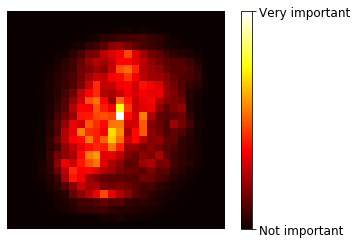

In [24]:
# Output each pixel's importance for MNIST dataset by using Extra-Trees
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
extra_trees_clf.fit(mnist['data'], mnist['target'])
feature_importances = extra_trees_clf.feature_importances_

# Plot each pixel's importance
plt.imshow(feature_importances.reshape((28, 28)),
           cmap=mpl.cm.hot, interpolation='nearest')
cbar = plt.colorbar(ticks=[feature_importances.min(), feature_importances.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.axis('off')
plt.show()

RF/Extra-Trees are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

### 3.4 Parameters

The <font color='blue'>main parameters to adjust</font> when using these methods (RF and Extra-Trees) are **`n_estimators`** and **`max_features`**.

- **`n_estimators`**: the number of trees in the forest. The larger the better, but also the longer it will take to compute. Note that results will stop getting significantly better beyond a critical number of trees.


- **`max_features`**: the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias.


- Empirical good default values are `max_features=None` (all features instead of a random subset) for regression tasks, and `max-features='sqrt'` (a random subset of size `sqrt(n_features)`) for classification tasks.


- Good results are often achieved when setting `max_depth=None` in combination with `min_samples_split=2` (i.e., when fully developing the trees).


- These values are usually not optimal, and might result in models that consume a lot of RAM. **<font color='blue'>The best parameter values should always be cross-validated.</font>**


- In RF, bootstrap samples are used by default (`bootstrap=True`) while the default strategy for Extra-Trees is to use the whole dataset (`bootstrap=False`). When using bootstrap sampling the generalization accuracy can be estimated on the left out or out-of-bag samples. This can be enabled by setting `oob_score=True`.

### 3.5 Parallelization (`n_jobs`)

This module also features the parallel construction of the trees and the parallel computation of the predictions through the **`n_jobs`** parameter.

- `n_jobs=k`: computations are partitioned into `k` jobs, and run on `k` cores of the machine.


- `n_job=-1`: all cores available on the machine are used.


<div class="alert alert-class alert-info">

<b>Note that because of inter-process communication overhead(费用), the speedup might not be linear (i.e., using k jobs will unfortunately not be k times as fast). Significant speedup can still be achieved though when building a large number of trees, or when building a single tree requires a fair amount of time (e.g., on large datasets).</b>

</div>

### 3.6 Totally Random Trees Embedding (Notice)

`RandomTreesEmbeding` **<font color='crimson'>implements an unsupervised transformation of the data</font>**.

It encodes the data by the indices of the leaves a data point ends up in by using a forest of completely random trees. The index is then encoded in a one-of-K manner, leading to a high-dimensional sparse representation. This coding can be computed very efficiently and can then be used as a basis for other learning tasks.

The size and sparsity of the code can be influenced by choosing the number of trees and the maximum depth per tree. For each tree in the ensemble, the coding contains one entry of one. The dimensionality of the resulting representation is `n_out <= n_estimators * max_leaf_nodes`. If `max_leaf_nodes = None`, the number of leaf nodes is at most `n_estimators * 2 ** max_depth`.

**<font color='crimson'>It provides a way to map data to a very high-dimensional, sparse space, in which linear clfs often achieve excellent accuracy. For sparse binary data, BernoulliNB is particularly well-suited.</font>**

In [25]:
from sklearn.ensemble import RandomTreesEmbedding

random_trees_embedding = RandomTreesEmbedding(
    n_estimators=100, max_depth=5, n_jobs=-1, random_state=42)
random_trees_embedding.fit(iris['data'], iris['target'])

RandomTreesEmbedding(max_depth=5, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     random_state=42, sparse_output=True, verbose=0,
                     warm_start=False)

In [26]:
# The completely random trees
random_trees_embedding.base_estimator_

ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                   max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.0, min_impurity_split=None,
                   min_samples_leaf=1, min_samples_split=2,
                   min_weight_fraction_leaf=0.0, random_state=None,
                   splitter='random')

In [27]:
iris_transformed = random_trees_embedding.transform(iris['data'])
iris_transformed

<150x2189 sparse matrix of type '<class 'numpy.float64'>'
	with 15000 stored elements in Compressed Sparse Row format>

In [28]:
# shape: (n_samples, n_out)
iris_transformed.shape

(150, 2189)

每行是每个 instance 在每棵树中所属叶子节点 index 的 one-hot 编码合并而成。

In [29]:
iris_transformed.toarray()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
iris_transformed.toarray().sum(axis=1)

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100.])

In [31]:
# the maximum of `n_out`
100 * 2 ** 5

3200

In [32]:
# Apply trees in the forests to `X`, return leaf indices.
# For each data point x in `X` and for each tree in the forest, return the
# index of the leaf x ends up in.
leaf_idx = random_trees_embedding.apply(iris['data'])
leaf_idx  # shape: (n_samples, n_estimators)

array([[ 6, 23,  8, ..., 10,  5, 17],
       [ 6, 23,  8, ..., 10,  5, 17],
       [ 6, 13,  8, ..., 10,  5,  6],
       ...,
       [24, 39, 38, ..., 28, 14, 35],
       [26, 39, 12, ..., 28, 25, 35],
       [23, 39, 12, ..., 28, 14, 18]])

每行表示每个 instance 在每棵树中所属叶子节点 index。

In [33]:
# shape: (n_samples, n_estimators)
leaf_idx.shape

(150, 100)

In [34]:
# The number of leaves nodes for each tree in the forest
leaf_num = []
for i in range(leaf_idx.shape[1]):
    leaf_num.append(len(set(leaf_idx[:, i])))
print(leaf_num)

[21, 21, 28, 23, 27, 25, 24, 17, 22, 27, 30, 15, 15, 22, 18, 16, 21, 27, 27, 24, 21, 28, 27, 23, 18, 29, 21, 26, 23, 23, 31, 25, 17, 19, 27, 19, 23, 21, 21, 26, 23, 23, 14, 18, 21, 24, 17, 22, 23, 20, 21, 20, 25, 17, 23, 22, 26, 25, 16, 30, 19, 28, 23, 22, 22, 25, 23, 27, 20, 16, 17, 16, 19, 20, 17, 24, 22, 28, 17, 15, 25, 27, 26, 27, 21, 21, 18, 13, 25, 24, 24, 17, 25, 17, 16, 25, 13, 19, 19, 19]


In [35]:
sum(leaf_num)

2189

In [36]:
print(set(leaf_idx[:, 0]))  # 第 1 棵树所有可能的 index

{4, 6, 7, 10, 11, 12, 16, 17, 19, 20, 23, 24, 26, 27, 32, 33, 35, 36, 38, 39, 40}


In [37]:
print("第 1 个样本在第 1 棵树中所属叶子 index:", leaf_idx[0, 0])
print("第 2 个样本在第 1 棵树中所属叶子 index:", leaf_idx[1, 0])
print("第 3 个样本在第 1 棵树中所属叶子 index:", leaf_idx[2, 0])

第 1 个样本在第 1 棵树中所属叶子 index: 6
第 2 个样本在第 1 棵树中所属叶子 index: 6
第 3 个样本在第 1 棵树中所属叶子 index: 6


所以，转换后样本在前 3 行（样本）都是以 "0, 1, 0, ..." 开头：

In [38]:
iris_transformed.toarray()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**<font color='blue'>More examples:</font>**

- [Hashing feature transformation using Totally Random Trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_embedding.html#sphx-glr-auto-examples-ensemble-plot-random-forest-embedding-py)


- [Feature transformations with ensembles of trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py): fit an ensemble of trees (totally random trees, a random forest, or gradient boosted trees)

## 4. Boosting

**<font color='red'>Boosting</font>** (originally called **<font color='red'>hypothesis boosting</font>**) refers to any Ensemble method that can <font color='crimson'>combine several weak learners into a strong learner</font>.

The general idea of most boosting methods is to **<font color='crimson'>train predictors sequentially, each trying to correct its predecessor</font>**.

### 4.1 AdaBoost

The <font color='crimson'>core principle of AdaBoost</font> is to fit a sequence of *weak learners* (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then **combined through a weighted majority vote (or sum) to produce the final prediction**.

![AdaBoost](./figs/chap07-figs/AdaBoost.png)
<Br>

The data modifications at each so-called boosting iteration consist of applying weights $w_1, w_2, ..., w_m$ to each of the training samples. Initially, those weights are all set to $w_i=1/m$ so that the first step simply trains a weak learner on the original data.

For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. <font color='crimson'>At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly.</font> As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence

<div class="alert alert-class alert-info">
    There is one <b>important drawback</b> to this sequential learning technique: it <b>cannot be parallelized (or only partially)</b>, since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it <b>does not scale as well as bagging or pasting</b>.
</div>

**<font color='blue'>Look at the AdaBoost algorithm:</font>**

Each instance weight $w_i$ is initially set to $1/m$. A first predictor is trained, and its weighted error rate $r_1$ is computed on the training set.

Weighted error rate of the $j^{th}$ predictor:

$$r_j=\frac{\sum^m_{\hat y_j^i\neq y^i}w_i}{\sum_{i=1}^m w_i}$$

The predictor weight is then computed using

$$\alpha_j=\eta log{\frac{1-r_j}{r_j}}$$

$\eta$ is the learning rate hyperparameter (default to 1). The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

Next, update the instance weights

$$w_i\leftarrow
\begin{cases}
w_i& \text{if } \hat y_j^i=y^i\\
w_i e^{\alpha_j}& \text{if } \hat y_j^i\neq y^i
\end{cases}$$

Then all the instance weights are normalized (i.e., divided by $\sum^m_{i=1}w_i$).

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). **The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.**

To predict, AdaBoost simply computes the predictions of all the predictors and weights them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes.

$$\hat y(x)={argmax}_k\sum^N_{j=1, \hat y_j(x)=k}{\alpha_j}, N \text{ is the number of predictors}$$

Scikit-Learn uses a **multiclass version of AdaBoost** called **<font color='red'>SAMME (Stagewise Additive Modeling using a Multiclass Exponential loss function)</font>**. If there are **just two classes**, SAMME is equivalent to AdaBoost. If the predictors can estimate class probabilities (have `predict_proba()`), Scikit-Learn can use a variant of SAMME called **<font color='red'>SAMME.R</font>** (the R stands for "Real"), which relies on class probabilities rather than prediction an generally performs better.

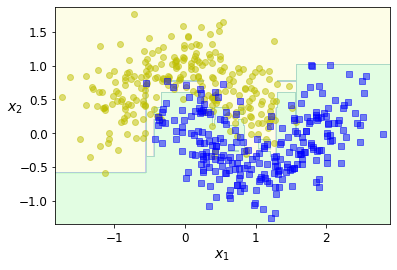

In [39]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    # A decision stump, composed of a single decision node plus two leaf nodes
    base_estimator=DecisionTreeClassifier(max_depth=1),  # Default
    n_estimators=200,
    algorithm='SAMME.R',
    learning_rate=0.5,
    random_state=42)
ada_clf.fit(x_train, y_train)

plot_decision_boundary(ada_clf, X, y)

The main parameters to tune to obtain good results are `n_estimators` and the complexity of the base estimators (e.g., its depth `max_depth` or minimum required number of samples to consider a split `min_samples_split`).

<div class="alert alert-class alert-info">
<b>If the AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.</b>
</div>

### 4.2 Gradient Boosting

[Gradient Boosting](https://homl.info/28) **works by sequentially adding predictors to an ensemble, each one correcting its predecessor** (前任) (just like AdaBoost). However, instead of tweaking the instance weights at every iteration (like AdaBoost), this methods <font color='crimson'>tries to fit the new predictor to the residual errors made by the previous predictor</font>.

Go through a simple regression example by using DT as the base predictors. This is called **<font color='red'>Gradient Tree Boosting</font>**, or **<font color='red'>Gradient Boosted Regression Trees (GBRT)</font>**.

In [40]:
# Generate data
np.random.seed(42)
x = np.random.rand(100, 1) - 0.5
y = 3 * x[:, 0]**2 + 0.05 * np.random.randn(100)

x.shape, y.shape

((100, 1), (100,))

In [41]:
from sklearn.tree import DecisionTreeRegressor

# 1st, fit a DT on the training set
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(x, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [42]:
# 2nd, fit a DT on the residual errors made by the 1st DT
y2 = y - tree_reg1.predict(x)

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(x, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [43]:
# 3rd, fit a DT on the residual errors made by the 2nd DT
y3 = y2 - tree_reg2.predict(x)

tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(x, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Now, we have an ensemble containing 3 trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [44]:
# Make predictions on a new instances simply adding up the predictions of all the trees
x_new = np.array([[0.8]])

y_pred = sum(tree.predict(x_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [45]:
def plot_predictions(regressors: list, x, y, label=None, style='r-',
                     data_style='b.', data_label=None):
    x_all = np.linspace(x.min(), x.max(), 500)
    x_all = x_all.reshape(-1, 1)
    y_pred = sum(regressor.predict(x_all) for regressor in regressors)
    plt.plot(x[:, 0], y, data_style, label=data_label)
    plt.plot(x_all, y_pred, style, lw=2, label=label)
    if label or data_label:
        plt.legend(fontsize=16)

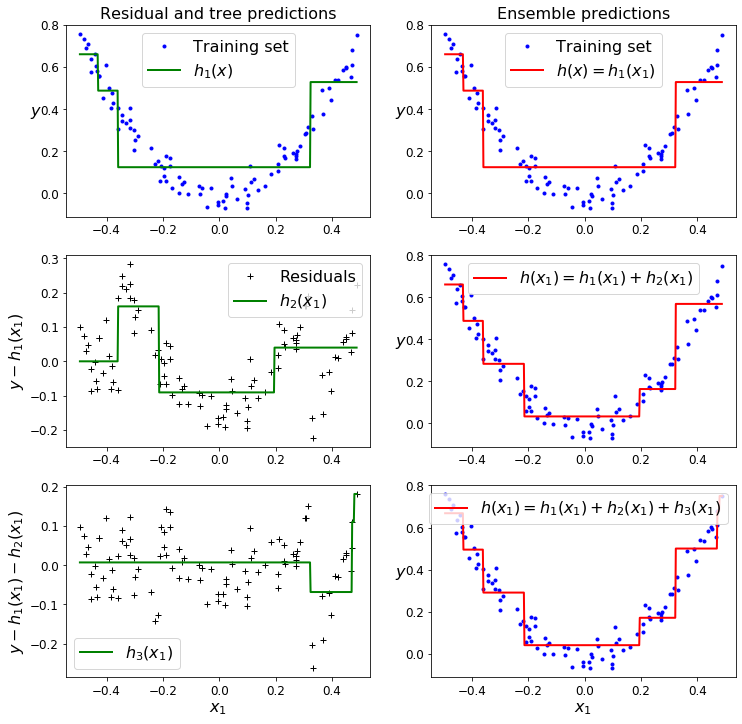

In [46]:
plt.figure(figsize=(12, 12))

# The 1st trained DT
plt.subplot(321)
plot_predictions([tree_reg1], x, y, label='$h_1(x)$',
                 style='g-', data_style='b.', data_label='Training set')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title("Residual and tree predictions", fontsize=16)

# The ensemble has just one DT
plt.subplot(322)
plot_predictions([tree_reg1], x, y, label='$h(x)=h_1(x_1)$',
                 style='r-', data_style='b.', data_label='Training set')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

# A new DT is trained on the residual errors of the 1st DT
plt.subplot(323)
plot_predictions([tree_reg2], x, y2, label='$h_2(x_1)$',
                 style='g-', data_style='k+', data_label='Residuals')
plt.ylabel('$y-h_1(x_1)$', fontsize=16)

# The ensemble's preds are equal to the sum of the preds of the first two DTs
plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], x, y, label='$h(x_1)=h_1(x_1)+h_2(x_1)$',
                 style='r-', data_style='b.')
plt.ylabel('$y$', fontsize=16, rotation=0)

# Another new DT is trained on the residual erros of the 2nd DT
plt.subplot(325)
plot_predictions([tree_reg3], x, y3, label='$h_3(x_1)$',
                 style='g-', data_style='k+', data_label=None)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$y-h_1(x_1)-h_2(x_1)$', fontsize=16)

# The ensemble's preds are the sum of preds of all the DTs
plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], x, y,
                 label='$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$',
                 style='r-', data_style='b.')
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

plt.show()

The above figure represents the predictions of these 3 DTs in the left column, and the ensemble's predictions in the right column.

**`GradientBoostingRegressor`** is a simpler way to train GBRT ensembles. It has hypyerparameters to control the growth of DT, as well as hyperparameters to control the ensemble training, such as the number of trees (`n_estimators`).

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(x, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
gbrt.predict(x_new)

array([0.75026781])

**<font color='crimson'>The `learning_rate` hyperparameter scales the contribution of each tree.</font>** **The `learning_rate` strongly interacts with the `n_estimators`.**

**Smaller values** require **larger numbers of weak learners** to maintain a constant training error, but predictions will usually **generalize better** (favor better test error). This is a regularization technique called **<font color='red'>shrinkage</font>**.
[HTF](https://scikit-learn.org/stable/modules/ensemble.html#id18) recommend to **<font color='crimson'>set a small constant learnin rate (e.g., <=0.1) and choose `n_estimators` by early stopping.</font>**

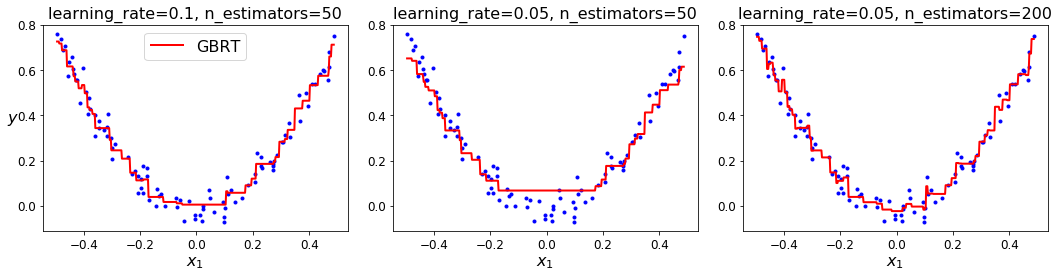

In [49]:
gbrt_1 = GradientBoostingRegressor(max_depth=2, n_estimators=50,
                                   learning_rate=0.1, random_state=42)
gbrt_1.fit(x, y)

gbrt_2 = GradientBoostingRegressor(max_depth=2, n_estimators=50,
                                   learning_rate=0.05, random_state=42)
gbrt_2.fit(x, y)

gbrt_3 = GradientBoostingRegressor(max_depth=2, n_estimators=200,
                                   learning_rate=0.05, random_state=42)
gbrt_3.fit(x, y)

plt.figure(figsize=(18, 3.8))

plt.subplot(131)
plot_predictions([gbrt_1], x, y, label='GBRT')
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title("learning_rate={}, n_estimators={}".format(gbrt_1.learning_rate, gbrt_1.n_estimators),
          fontsize=16)

plt.subplot(132)
plot_predictions([gbrt_2], x, y)
plt.xlabel('$x_1$', fontsize=16)
plt.title("learning_rate={}, n_estimators={}".format(gbrt_2.learning_rate, gbrt_2.n_estimators),
          fontsize=16)

plt.subplot(133)
plot_predictions([gbrt_3], x, y)
plt.xlabel('$x_1$', fontsize=16)
plt.title("learning_rate={}, n_estimators={}".format(gbrt_3.learning_rate, gbrt_3.n_estimators),
          fontsize=16)

plt.subplots_adjust(wspace=0.15)
plt.show()


#### 4.2.1 Gradient boosting with early stopping

**<font color='blueviolet'>In order to find the optimal number of trees, you can use early stopping.</font>**

- **<font color='blueviolet'>Way 1:</font>**

Use the **`staged_predict()`** method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one DT, two DT, etc.). It allows monitoring (i.e., determine error on test set) after each stage.

In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.25, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(x_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(x_val)]
best_n_estimators = np.argmin(errors) + 1
gbrt_best = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=best_n_estimators,
                                      random_state=42)
gbrt_best.fit(x_train, y_train)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [51]:
len(errors), gbrt.n_estimators

(120, 120)

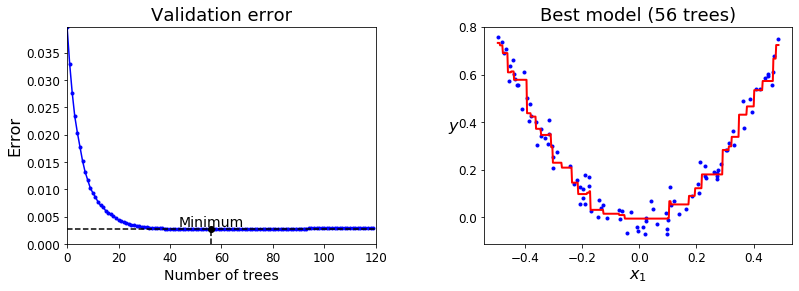

In [52]:
min_error = np.min(errors)
plt.figure(figsize=(13, 4))

# Staged error on val set
plt.subplot(121)
plt.plot(errors, 'b.-')
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], 'k--')
plt.plot([0, 120], [min_error, min_error], 'k--')
plt.plot(best_n_estimators, min_error, 'ko')
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, np.max(errors)])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=18)

# Early stopping with GBRT
plt.subplot(122)
plot_predictions([gbrt_best], x, y)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=18)

plt.subplots_adjust(wspace=0.35)
plt.show()

- **<font color='blueviolet'>Way 2:</font>**

Set **`warm_start=True`** to implement actual stopping training early (instead of training a large number of trees first and then looking back to find the optimal number).

**`warm_start=True` makes sklearn keep existing trees when the `fit()` method is called, allowing incremental training.**

In [60]:
gbrt = GradientBoostingRegressor(
    max_depth=2,
    # Reuse the solution of the previous call to fit and
    # add more estimators to the ensemble
    warm_start=True,
    random_state=42)

# Stop training when the validation error does not improve for 5 iterations in a row
min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 200):
    gbrt.n_estimators = n_estimators
    gbrt.fit(x_train, y_train)

    y_pred = gbrt.predict(x_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [61]:
gbrt.n_estimators

61

In [62]:
gbrt.n_estimators_

61

In [63]:
# Minimum validation MSE
min_val_error

0.002712853325235463

- **<font color='blueviolet'>Way 3:</font>**

Set **`n_iter_no_change`** to a number, it will set aside `validation_fraction` size of the training data as validation and terminate training when validation score is not improving in all of the previous `n_iter_no_change` numbers of iterations.

In [64]:
gbrt = GradientBoostingRegressor(
    n_estimators=10000,
    max_depth=2,
    # Set aside validation_fraction size of the training data as validation and
    # terminate training when validation score is not improving in all of the
    # previous n_iter_no_change numbers of iterations.
    validation_fraction=0.25,
    n_iter_no_change=5,
    random_state=42)
gbrt.fit(x, y)

gbrt.n_estimators, gbrt.n_estimators_

(10000, 52)

An optimized implementation of Gradient Boosting is available in XGBoost, which stands for Extreme Gradient Boosting. It aims to be extremely fast, scalable, and portable.

```python
import xgboost

# Take care of early stopping
xgb_reg.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=2)

y_pred = xgb_reg.predict(x_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)
```

#### 4.2.2 Gradient boosting with subsampling (Stochastic Gradient Boosting)

**<font color='red'>Stochastic Gradient Boosting</font>** combines gradient boosting with bootstrap averaging (bagging). At each iteration the tree is trained on a fraction **`subsample`** of the available training data. **The subsample is drawn without replacement.** <font color='crimson'>A typical value of subsample is 0.5</font>, then each tree is trained on 50% of the training data, selected randomly.

<font color='crimson'>This technique trades a higher bias for a lower variance. It also speeds up training considerably.</font>

<div class="alert alert-block alert-info">

<b>Regularization strategies for Gradient Boosting</b>
- shrinkage


- subsampling
</div>

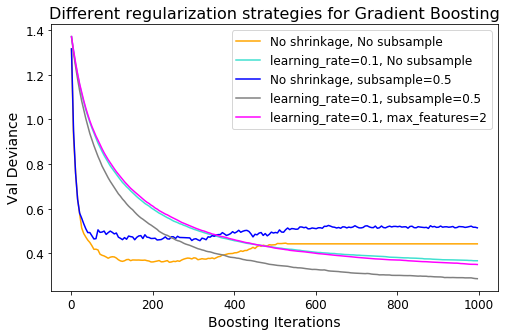

In [65]:
# Compare the effect of different regularization strategies for Gradient Boosting
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

# Generates data for binary classification used in Hastie et al. 2009, Example 10.2.
# The ten features are standard independent Gaussian and the target y is defined by:
# y[i] = 1 if np.sum(X[i] ** 2) > 9.34 else -1
x, y = make_hastie_10_2(n_samples=12000, random_state=1)
x = x.astype(np.float32)
# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

x_train, x_val = x[:2000], x[2000:]
y_train, y_val = y[:2000], y[2000:]

original_params = {
    'n_estimators': 1000,
    'max_leaf_nodes': 4,
    'max_depth': None,
    'random_state': 2,
    'min_samples_split': 5,
}

settings = [
    ('No shrinkage, No subsample', 'orange', {'learning_rate': 1.0, 'subsample': 1.0}),
    ('learning_rate=0.1, No subsample', 'turquoise', {'learning_rate': 0.1, 'subsample': 1.0}),
    ('No shrinkage, subsample=0.5', 'blue', {'learning_rate': 1.0, 'subsample': 0.5}),
    ('learning_rate=0.1, subsample=0.5', 'gray', {'learning_rate': 0.1, 'subsample': 0.5}),
    ('learning_rate=0.1, max_features=2', 'magenta', {'learning_rate': 0.1, 'max_features': 2})]

plt.figure(figsize=(8, 4.9))
for label, c, param in settings:
    params = dict(param)
    params.update(original_params)

    clf = GradientBoostingClassifier(**params)
    clf.fit(x_train, y_train)

    # Compute val set deviance
    val_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(x_val)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        val_deviance[i] = clf.loss_(y_val, y_pred)

    plt.plot((np.arange(val_deviance.shape[0])+1)[::5], val_deviance[::5],
             '-', color=c, label=label)

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Boosting Iterations', fontsize=14)
plt.ylabel('Val Deviance', fontsize=14)
plt.title("Different regularization strategies for Gradient Boosting", fontsize=16)
plt.show()

**<font color='crimson'>Summary:</font>**

- Regularization via shrinkage (`learning_rate` < 1.0) improves performance considerably.


- In combination with shrinkage, stochastic gradient boosting (`subsample` < 1.0) can produce more accurate models by reducing the variance via bagging.


- Subsampling without shrinkage usually does poorly.


- Another strategy to reduce the variance is by subsampling the features analogous to the random splits in `RandomForestClassifier`.

## 5. Stacking

**<font color='red'>Stacking (stacked generalization)</font>** is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we **train a model to perform this aggregation**?

[sklearn](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization)
It is an ensemble method for <font color='crimson'>combining estimators to reduce their biases</font> [1992 paper](http://machine-learning.martinsewell.com/ensembles/stacking/Wolpert1992.pdf). <font color='crimson'>The predictions of each individual estimator are stacked together and used as input to a final estimator to compute the prediction. The final estimator is trained through cross-validation.</font>

![](./figs/chap07-figs/aggregating-predictions-using-a-blending-predictor.png)
<center><i>Aggregating predictions using a blending predictor</i></center>

The figure shows such an ensemble performing a regression task on a new instance. Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then **the final predictor** (called a **<font color='red'>blender</font>**, or a **<font color='red'>meta learner</font>**) takes these predictions as inputs and makes the final prediction (3.0).


<font color='crimson'>To train the blender, a common approach is to use a hold-out set.</font>

First, the training set is split into two subsets. The first subset is used to train the predictors in the first layer.

![Training the first layer](./figs/chap07-figs/training-for-1st-layer.png)
<center><i>Training the first layer</i></center>

Next, the first layer’s predictors are used to make predictions on the second (held-out) sets. This ensures that the predictions are “clean”, since the predictors never saw these instances during training. For each instance in the hold-out set, there are three predicted values. We can create a new training set using these predicted values as input features (which makes this new training set 3D), and keeping the target values. The blender is trained on this new training set, so it learns to predict the target value, given the first layer’s predictions.


![Training the blender](./figs/chap07-figs/train-the-blender.png)
<center><i>Training the blender</i></center>

<br>

<font color='crimson'>It is actually possible to train several different blenders this way to get a whole layer of blenders.</font> The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer). Once this is done, we can make a prediction for a new instance by going through each layer sequentially

![Predictions in a multilayer stacking ensemble](./figs/chap07-figs/predictions-in-a-multilayer-stacking-enseble.png)
<center><i>Predictions in a multilayer stacking ensemble</i></center>

**<font color='crimson'>Implementation:</font>**

1. [Scikit-Learn >= 0.22](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization). 

2. [DESlib](https://github.com/scikit-learn-contrib/DESlib)

### 5.1 Scikit-Learn implementation

The predictions of each individual estimator are stacked together and used as input to a final estimator to compute the prediction. **This final estimator is trained through cross-validation.** The [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) and [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor) provide such strategies which can be applied to classification and regression problems.

The **`estimators`** parameter corresponds to the list of the estimators which are stacked together **in parallel on the input data**. It should be **given as a list of names and estimators**:

In [66]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

# List of (name_str, estimator)
estimators = [
    ('ridge', Ridge(random_state=42)),
    ('lasso', Lasso(random_state=42)),
    ('svr', SVR(C=1, gamma=1e-6))
]

The **`final_estimator`** will use the predictions of the estimators as input. It needs to be a classifier or a regressor when using `StackingClassifier` or `StackingRegressor`, respectively:

In [67]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

reg = StackingRegressor(
    estimators=estimators,
    # A regressor which will be used to combine the base estimators.
    # The default regressor is a `RidgeCV`.
    final_estimator=GradientBoostingRegressor(random_state=42),
    cv=None,  # Default, use 5-fold cv
    n_jobs=-1)

In [68]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

x, y = load_boston(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

# Train the `estimators` and `final_estimator`
reg.fit(x_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('ridge',
                               Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                     max_iter=None, normalize=False,
                                     random_state=42, solver='auto',
                                     tol=0.001)),
                              ('lasso',
                               Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                                     max_iter=1000, normalize=False,
                                     positive=False, precompute=False,
                                     random_state=42, selection='cyclic',
                                     tol=0.0001, warm_start=False)),
                              (...
                                                            max_depth=3,
                                                            max_features=None,
                                                            max_leaf_node

In [69]:
# The elements of the estimators parameter, having been fitted on the training data.
reg.estimators_

[Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=42, solver='auto', tol=0.001),
 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=42,
       selection='cyclic', tol=0.0001, warm_start=False),
 SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-06,
     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)]

In [70]:
# Attribute to access any fitted sub-estimators by name.
reg.named_estimators_

{'ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=42, solver='auto', tol=0.001),
 'lasso': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=42,
       selection='cyclic', tol=0.0001, warm_start=False),
 'svr': SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-06,
     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)}

In [71]:
# The regressor to stacked the base estimators fitted.
reg.final_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

During training, **the `estimators` are fitted on the whole training data `x_train`**. They will be used when calling `predict` or `predict_proba`.

**To generalize and avoid over-fitting, the `final_estimator` is trained on out-samples using `sklearn.model_selection.cross_val_predict` internally.**

For **`StackingClassifier`**, note that the output of the estimators is controlled by the parameter **`stack_method`** (a string) and it is called by each estimator.

- `'auto'`, it will try to invoke, for each estimator, `'predict_proba'`, `'decision_function'` or `'predict'` in that order.

- otherwise, one of 'predict_proba', 'decision_function' or 'predict'. If the method is not implemented by the estimator, it will raise an error.

In [72]:
from sklearn.metrics import r2_score

y_pred = reg.predict(x_test)
print('R2 score: {:.2f}'.format(r2_score(y_test, y_pred)))

R2 score: 0.79


In [73]:
# Return the predictions for X for each estimator
reg.transform(x_test[:1])

array([[28.69407967, 28.46688043, 22.61898964]])

In [74]:
y[:1]

array([24.])

<div class="alert alert-block alert-info">
    <b>In practise, a stacking predictor predict as good as the best predictor of the base layer and even sometimes outputperform it by combining the different strength of the these predictors. However, training a stacking predictor is computationally expensive.</b>
</div>

**See all parameters by `reg.get_params().keys()`.**

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'ridge__alpha': [0.1, 1., 10.],
    'lasso__alpha': [0.1, 1., 10.],
    'svr__C': [0.1, 1., 10.],
    'final_estimator__max_depth': [1, 2, 3, 4],
    'final_estimator__n_estimators': [100, 150, 200]
}
grid_search = GridSearchCV(reg, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingRegressor(cv=None,
                                         estimators=[('ridge',
                                                      Ridge(alpha=1.0,
                                                            copy_X=True,
                                                            fit_intercept=True,
                                                            max_iter=None,
                                                            normalize=False,
                                                            random_state=42,
                                                            solver='auto',
                                                            tol=0.001)),
                                                     ('lasso',
                                                      Lasso(alpha=1.0,
                                                            copy_X=True,
                                           

In [76]:
grid_search.best_params_

{'final_estimator__max_depth': 4,
 'final_estimator__n_estimators': 100,
 'lasso__alpha': 10.0,
 'ridge__alpha': 0.1,
 'svr__C': 10.0}

In [77]:
y_pred = grid_search.predict(x_test)
print('R2 score: {:.2f}'.format(r2_score(y_test, y_pred)))

R2 score: 0.79


In [78]:
grid_search.best_estimator_

StackingRegressor(cv=None,
                  estimators=[('ridge',
                               Ridge(alpha=0.1, copy_X=True, fit_intercept=True,
                                     max_iter=None, normalize=False,
                                     random_state=42, solver='auto',
                                     tol=0.001)),
                              ('lasso',
                               Lasso(alpha=10.0, copy_X=True,
                                     fit_intercept=True, max_iter=1000,
                                     normalize=False, positive=False,
                                     precompute=False, random_state=42,
                                     selection='cyclic', tol=0.0001,
                                     warm_start=False)),...
                                                            max_depth=4,
                                                            max_features=None,
                                                            max_lea

**<font color='crimson'>Multiple stacking layers can be achieved by assigning final_estimator to a `StackingClassifier` or `StackingRegressor`.</font>**

In [79]:
from sklearn.ensemble import RandomForestRegressor

final_layer = StackingRegressor(
    estimators=[('rf', RandomForestRegressor(random_state=42)),
                ('gbrt', GradientBoostingRegressor(random_state=42))],
    # Default None, use `RidgeCV()`
    final_estimator=None)
multi_layer_regressor = StackingRegressor(
    estimators=[('ridge', Ridge(random_state=42)),
                ('lasso', Lasso(random_state=42)),
                ('svr', SVR(C=1, gamma=1e-6))],
    final_estimator=final_layer,
    n_jobs=-1)

multi_layer_regressor.fit(x_train, y_train)
print('R2 score: {:.2f}'.format(multi_layer_regressor.score(x_test, y_test)))

R2 score: 0.82
